In [1]:
from fembem import FEM_BEM_Solver
import numpy as np
import matplotlib.pyplot as plt

Time to assemble FEM matrices: 0.91 seconds
Time to assemble strong MoM matrix: 11.60 seconds
The shape of K is: (1322, 1322)
The shape of B is: (1322, 256)
The shape of P is: (256, 1322)
The shape of Q is: (256, 256)
Time to solve coupled system: 0.64 seconds


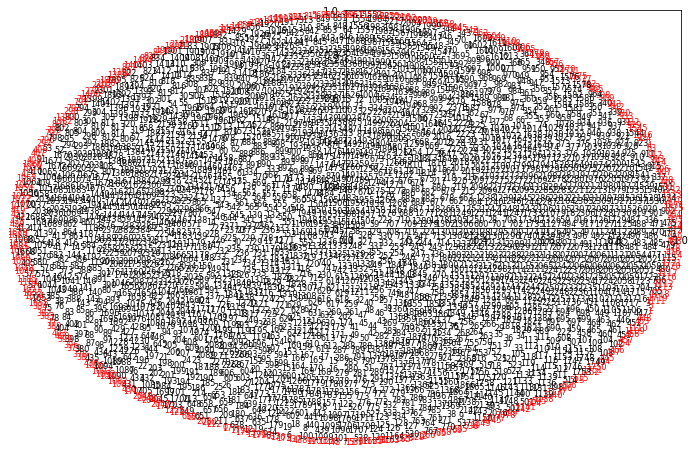

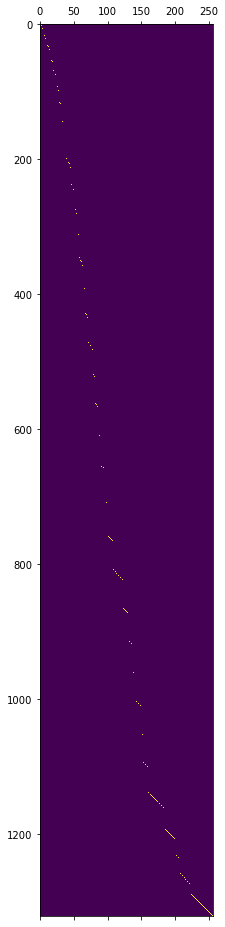

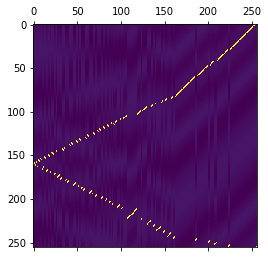

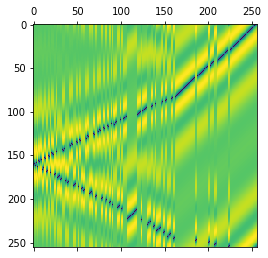

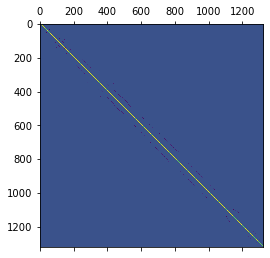

In [4]:
solver = FEM_BEM_Solver(
    N_boundary=256,
    n_rings=19, 
    kb=2*np.pi, 
    epsi=2.0, 
    mui=1.0, 
    max_dim=(3,3), 
    resolution=50, 
    radius=1.0
)

# Execute the solver and capture the results
phi, psi, dof_coordinates = solver.run()


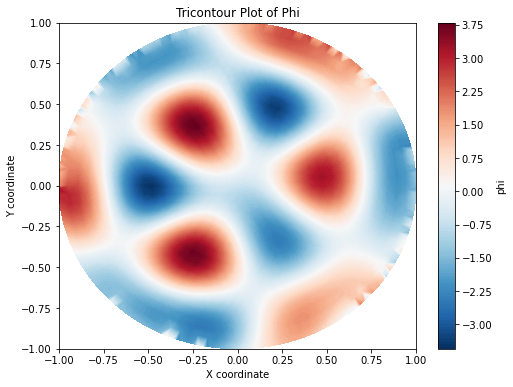

In [3]:
# Extract x and y coordinates
x = dof_coordinates[:, 0]
y = dof_coordinates[:, 1]

# Create a tricontour plot
plt.figure(figsize=(8, 6))
#plt.tricontour(x, y, phi.real, levels=14, linewidths=0.5, colors='k')
plt.tricontourf(-x, y, phi.real, levels=146, cmap="RdBu_r")
plt.colorbar(label='phi')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Tricontour Plot of Phi')
plt.show()